# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Examining Explained Returns of securities around FOMC meetings

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

All returns and returns-statistics were calculated via basis points and not returns

## Packages

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
from EventDrivenSignalGenerator import EventDrivenSignalGenerator

## Data Prep

In [4]:
def get_tsy() -> pd.DataFrame: 
    
    df_tsy = (EventDrivenSignalGenerator().get_tsy_futures().rename(
        columns = {"security": "variable"}).
        assign(variable = lambda x: x.variable.str.split(" ").str[0]))
    
    return df_tsy

def get_tsy_window(df_tsy: pd.DataFrame, before: int = -6, after: int = 1) -> pd.DataFrame:
    
    df_out = (EventDrivenSignalGenerator().get_ordered_window(
        df     = df_tsy,
        before = before,
        after  = after))
    
    return df_out

df_tsy    = get_tsy()
df_window = get_tsy_window(df_tsy)

## Cumulative bps around FOMC Days

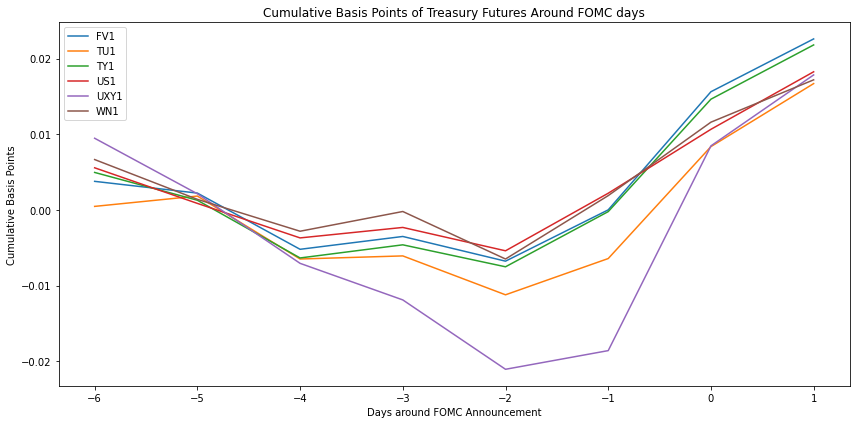

In [4]:
def plot_cumulative_bps_around_fomc(df_tsy: pd.DataFrame, before: int = -6, after: int = 1) -> plt.Figure: 

    (df_window[
        ["variable", "PX_bps", "day"]].
        groupby(["day", "variable"]).
        agg("mean").
        reset_index().
        rename(columns = {"variable": ""}).
        pivot(index = "day", columns = "", values = "PX_bps").
        cumsum().
        plot(
            figsize = (12,6),
            xlabel  = "Days around FOMC Announcement",
            ylabel  = "Cumulative Basis Points",
            title   = "Cumulative Basis Points of Treasury Futures Around FOMC days"))

    plt.tight_layout()
    
plot_cumulative_bps_around_fomc(df_tsy)

Build a Naive strategy that buys 3 days before and sells the day before.

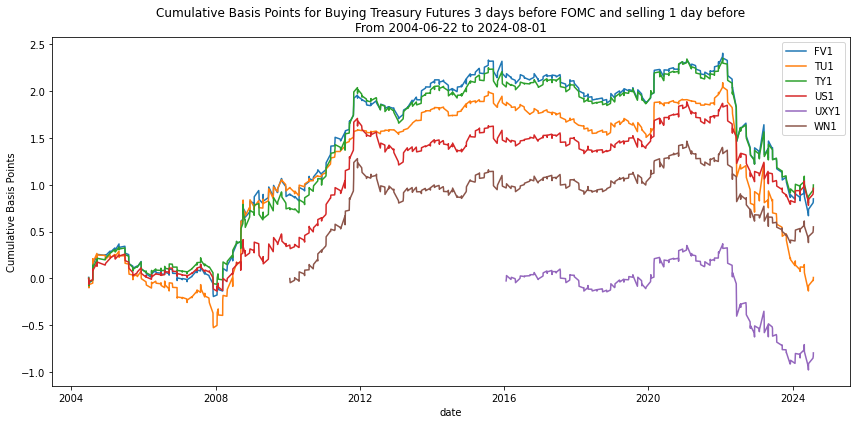

In [5]:
def plot_naive_strategy(df_window: pd.DataFrame, start_trade: int = -3, end_trade: int = -1) -> plt.Figure: 

    (df_window.query(
        "@start_trade <= day <= @end_trade")
        [["date", "variable", "PX_bps"]].
        rename(columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "PX_bps").
        cumsum().
        plot(
            ylabel  = "Cumulative Basis Points",
            figsize = (12,6),
            title   = "Cumulative Basis Points for Buying Treasury Futures 3 days before FOMC and selling 1 day before\nFrom {} to {}".format(
                df_window.date.min(),
                df_window.date.max())))

    plt.tight_layout()
    
plot_naive_strategy(df_window)

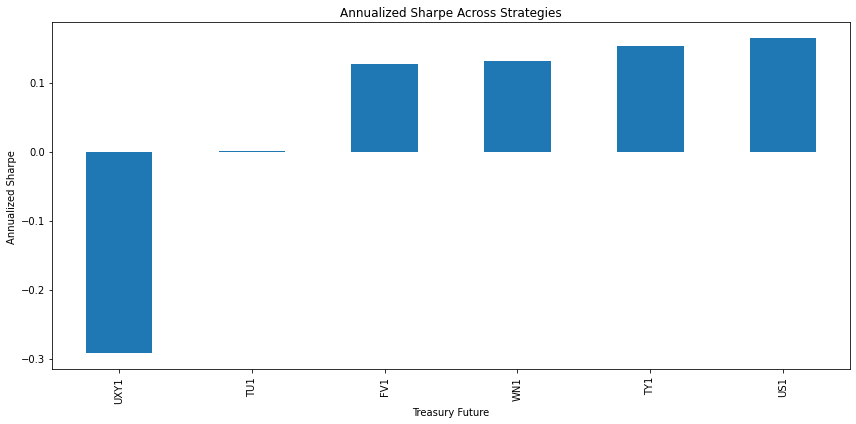

In [6]:
def plot_naive_strategy_sharpe(df_window: pd.DataFrame, start_trade: int = -3, end_trade: int = -1) -> plt.Figure: 

    fig, ax = plt.subplots(figsize = (12,6))

    (df_window.query(
        "@start_trade <= day <= @end_trade")
        [["variable", "PX_bps"]].
        groupby("variable").
        agg(["mean", "std"])
        ["PX_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8 * (abs(start_trade - end_trade))))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            ax     = ax,
            kind   = "bar",
            xlabel = "Treasury Future",
            ylabel = "Annualized Sharpe",
            legend = False,
            title  = "Annualized Sharpe Across Strategies"))

    plt.tight_layout()
    
plot_naive_strategy_sharpe(df_window)

## Cumulative bps around FOMC Days conditioned on FOMC oucome

In [7]:
def get_event_outcome() -> pd.DataFrame: 
    
    df_namer = (pd.DataFrame({
        "rate_change": [-1, 0, 1],
        "result"     : ["Cut", "Hold", "Hike"]}))

    df_event_outcome = (EventDrivenSignalGenerator().get_fed_funds().sort_values(
        "date").
        set_index("date").
        diff().
        dropna().
        assign(rate_change = lambda x: np.sign(x.FDTR)).
        reset_index().
        merge(right = df_namer, how = "inner", on = ["rate_change"]))
    
    return df_event_outcome

df_event_outcome = get_event_outcome()

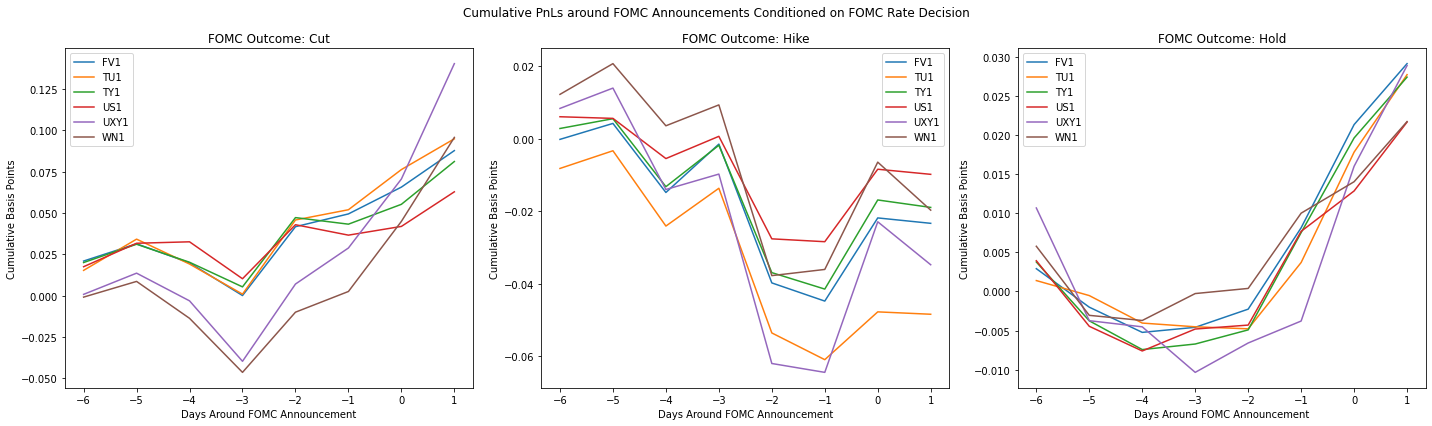

In [8]:
def plot_cumulative_bps_around_conditional_fomc(df_window: pd.DataFrame, df_event_outcome: pd.DataFrame) -> plt.Figure: 
    
    df_result = (df_window.query(
        "day == 0")
        [["date", "event"]].
        drop_duplicates().
        merge(right = df_event_outcome, how = "inner", on = ["date"])
        [["event", "result"]])

    df_rtn = (df_result.merge(
        right = df_window, how = "inner", on = ["event"])
        [["result", "variable", "day", "PX_bps"]].
        groupby(["result", "variable", "day"]).
        agg("mean").
        reset_index())

    results   = df_rtn.result.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(results), figsize = (20,6))

    for result, ax in zip(results, axes.flatten()): 

        (df_rtn.query(
            "result == @result").
            drop(columns = ["result"]).
            rename(columns = {"variable": ""}).
            pivot(index = "day", columns = "", values = "PX_bps").
            cumsum().
            plot(
                ax     = ax,
                xlabel = "Days Around FOMC Announcement",
                ylabel = "Cumulative Basis Points",
                title  = "FOMC Outcome: {}".format(result)))

    fig.suptitle("Cumulative PnLs around FOMC Announcements Conditioned on FOMC Rate Decision")
    plt.tight_layout()
    
plot_cumulative_bps_around_conditional_fomc(df_window, df_event_outcome)

We can look at the sharpes conditioned on the trade outcome across products

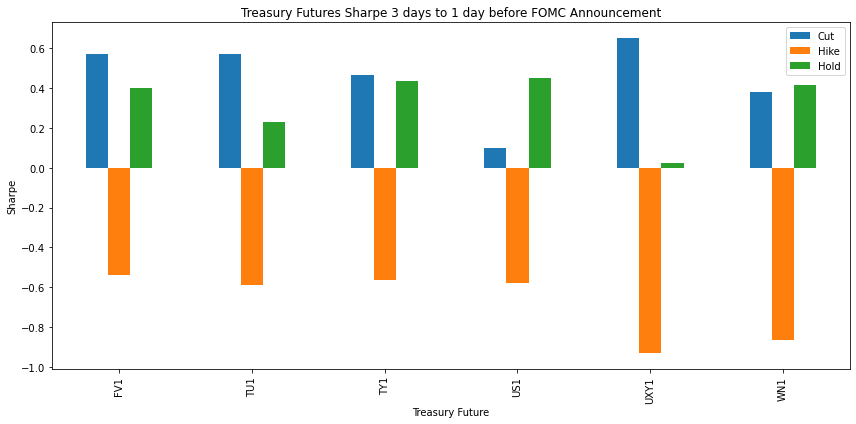

In [13]:
def get_sharpe_fomc_conditioned(df_window: pd.DataFrame, df_event_outcome: pd.DataFrame, start_trade: int = -3, end_trade: int = -1) -> plt.Figure: 

    df_result = (df_window.query(
        "day == 0")
        [["date", "event"]].
        drop_duplicates().
        merge(right = df_event_outcome, how = "inner", on = ["date"])
        [["event", "result"]])

    (df_result.merge(
        right = df_window, how = "inner", on = ["event"]).
        query("@start_trade <= day <= @end_trade")
        [["result", "variable", "PX_bps"]].
        groupby(["result", "variable"]).
        agg(["mean", "std"])
        ["PX_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8 * abs(start_trade - end_trade)))
        [["sharpe"]].
        reset_index().
        rename(columns = {"result": ""}).
        pivot(index = "variable", columns = "", values = "sharpe").
        plot(
            figsize = (12,6),
            kind    = "bar",
            xlabel  = "Treasury Future",
            ylabel  = "Sharpe",
            title   = "Treasury Futures Sharpe {} days to {} day before FOMC Announcement".format(
                -1 * start_trade,
                -1 * end_trade)))

    plt.tight_layout()
    
get_sharpe_fomc_conditioned(df_window, df_event_outcome)

It appears that the relationship proposed in the strategy doesn't hold when there is cuts. In this case if we built a hypothetical return where we are long futures when there is a cut / hold and short futures when there is a hike. 

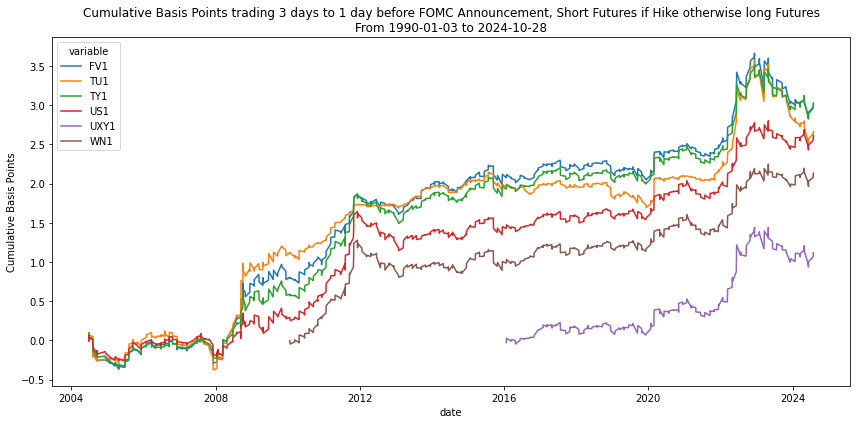

In [10]:
def plot_cumulative_returns_conditional_fomc(
    df_window       : pd.DataFrame, 
    df_event_outcome: pd.DataFrame, 
    start_trade     : int = -3, 
    end_trade       : int = -1) -> plt.Figure:

    df_result = (df_window.query(
        "day == 0")
        [["date", "event"]].
        drop_duplicates().
        merge(right = df_event_outcome, how = "inner", on = ["date"])
        [["event", "result"]])

    (df_window.merge(
        right = df_result, how = "inner", on = ["event"]).
        assign(signal_bps = lambda x: np.where(x.result == "Hike", -1 * x.PX_bps, x.PX_bps)).
        query("@start_trade <= day <= @end_trade")
        [["variable", "date", "signal_bps"]].
        pivot(index = "date", columns = "variable", values = "signal_bps").
        cumsum().
        plot(
            figsize = (12,6),
            ylabel  = "Cumulative Basis Points",
            title   = "Cumulative Basis Points trading 3 days to 1 day before FOMC Announcement, Short Futures if Hike otherwise long Futures\nFrom {} to {}".format(
                df_event_outcome.date.min(),
                df_event_outcome.date.max())))
    
    plt.tight_layout()
    
plot_cumulative_returns_conditional_fomc(df_window, df_event_outcome)

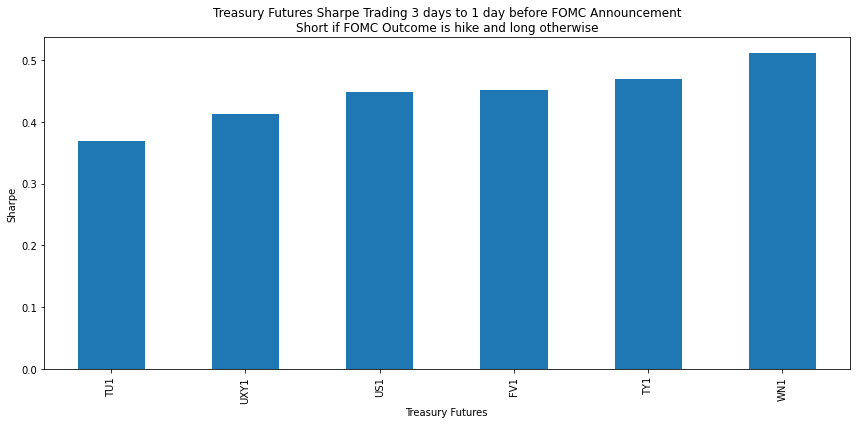

In [14]:
def plot_sharpe_conditional_fomc(
    df_window       : pd.DataFrame, 
    df_event_outcome: pd.DataFrame,
    start_trade     : int = -3,
    end_trade       : int = -1) -> plt.Figure: 
    
    df_result = (df_window.query(
        "day == 0")
        [["date", "event"]].
        drop_duplicates().
        merge(right = df_event_outcome, how = "inner", on = ["date"])
        [["event", "result"]])

    (df_window.merge(
        right = df_result, how = "inner", on = ["event"]).
        assign(signal_bps = lambda x: np.where(x.result == "Hike", -1 * x.PX_bps, x.PX_bps)).
        query("@start_trade <= day <= @end_trade")
        [["variable", "signal_bps"]].
        groupby("variable").
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8 * abs(start_trade - end_trade)))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            figsize = (12,6),
            kind    = "bar",
            legend  = False,
            ylabel  = "Sharpe",
            xlabel  = "Treasury Futures",
            title   = "Treasury Futures Sharpe Trading 3 days to 1 day before FOMC Announcement\nShort if FOMC Outcome is hike and long otherwise"))

    plt.tight_layout()
    
plot_sharpe_conditional_fomc(df_window, df_event_outcome)

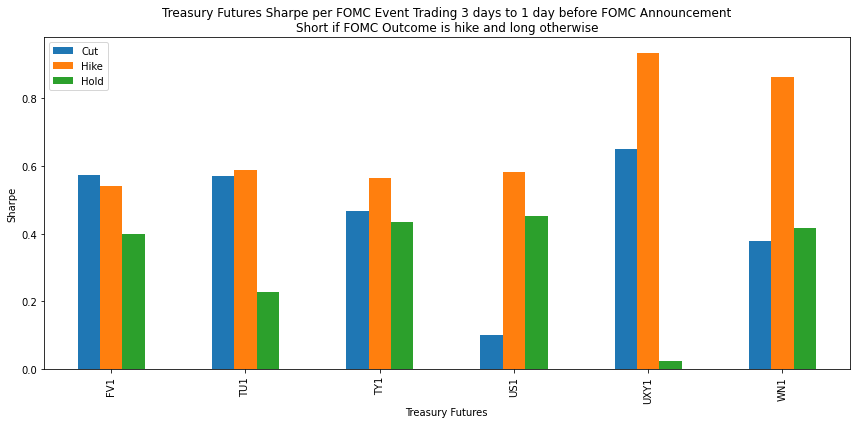

In [15]:
def plot_sharpe_per_event_conditional_fomc(
    df_window       : pd.DataFrame, 
    df_event_outcome: pd.DataFrame,
    start_trade     : int = -3,
    end_trade       : int = -1) -> plt.Figure: 
    
    df_result = (df_window.query(
        "day == 0")
        [["date", "event"]].
        drop_duplicates().
        merge(right = df_event_outcome, how = "inner", on = ["date"])
        [["event", "result"]])

    (df_window.merge(
        right = df_result, how = "inner", on = ["event"]).
        assign(signal_bps = lambda x: np.where(x.result == "Hike", -1 * x.PX_bps, x.PX_bps)).
        query("@start_trade <= day <= @end_trade")
        [["variable", "signal_bps", "result"]].
        groupby(["variable", "result"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8 * abs(start_trade - end_trade))).
        reset_index()
        [["variable", "result", "sharpe"]].
        rename(columns = {"result": ""}).
        pivot(index = "variable", columns = "", values = "sharpe").
        plot(
            figsize = (12,6),
            kind    = "bar",
            xlabel  = "Treasury Futures",
            ylabel  = "Sharpe",
            title   = "Treasury Futures Sharpe per FOMC Event Trading 3 days to 1 day before FOMC Announcement\nShort if FOMC Outcome is hike and long otherwise"))

    plt.tight_layout()
    
plot_sharpe_per_event_conditional_fomc(df_window, df_event_outcome)